In [1]:
import pandas as pd    
import geopandas as gpd
from geopandas.tools import geocode
#import geoplot
from shapely.geometry import Point
import numpy as np
import scipy.stats as stats
import scipy
import shapely
from shapely import speedups
speedups.enabled
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

**GeoJson files**

In [2]:
#Census tracts
census_url = 'https://opendata.arcgis.com/datasets/de58dc3e1efc49b782ab357e044ea20c_9.geojson'
census_bounds = gpd.read_file(census_url)
census_bounds.head()

,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length,SHAPE_Area,geometry
0,1,2500,002500,53033002500,25,Census Tract 25,243.219083,0,16442.968402,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6..."
1,2,2600,002600,53033002600,26,Census Tract 26,307.584420,0,15936.137058,1.339838e+07,"POLYGON ((-122.30817 47.69031, -122.30947 47.6..."
2,3,5600,005600,53033005600,56,Census Tract 56,737.511727,0,30337.294354,3.212601e+07,"POLYGON ((-122.39300 47.63956, -122.39421 47.6..."
3,4,6800,006800,53033006800,68,Census Tract 68,177.438771,0,11275.376490,7.729233e+06,"POLYGON ((-122.35070 47.63994, -122.35130 47.6..."
4,5,6000,006000,53033006000,60,Census Tract 60,324.567432,0,19729.922875,1.413816e+07,"POLYGON ((-122.34279 47.64320, -122.34280 47.6..."


In [ ]:
#Bike lanes and walkways
#Bike lane index == 6
#Walkway index == 5

#df_SND = gpd.read_file('Street_Network_Database_SND.geojson')

Download at the link in the websites google doc and go to APIs to download as GeoJSON

In [3]:
#Bike racks
racks_url = 'https://opendata.arcgis.com/datasets/f86c29ce743e47819e588c3d643ceb63_0.geojson'
racks_data = gpd.read_file(racks_url)

In [ ]:
#Parking -- having some trouble with downloading this one, will explain in zoom

In [4]:
#Population -- don't have recent population data by Census tract, may have to estimate tract-specific
              #populations by relative area fraction of census tract from the total Seattle fraction
              #by year (this data we have).
        
seattle_pop = pd.read_csv('City_Annual_Stats.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'City_Annual_Stats.csv'

Population download link: https://data-seattlecitygis.opendata.arcgis.com/datasets/0920ecc5b00446629b55fd7e668d9b97_3.csv?outSR=%7B%22latestWkid%22%3A2926%2C%22wkid%22%3A2926%7D

_Traffic Flows_

In [15]:
url_list = ['https://opendata.arcgis.com/datasets/7015d5d46a284f94ac05c2ea4358bcd7_0.geojson',
            'https://opendata.arcgis.com/datasets/5fc63b2a48474100b560a7d98b5097d7_1.geojson',
            'https://opendata.arcgis.com/datasets/27af9a2485c5442bb061fa7e881d7022_2.geojson',
            'https://opendata.arcgis.com/datasets/4f62515558174f53979b3be0335004d3_3.geojson',
            'https://opendata.arcgis.com/datasets/29f801d03c9b4b608bca6a8e497278c3_4.geojson',
            'https://opendata.arcgis.com/datasets/a0019dd0d6464747a88921f5e103d509_5.geojson',
            'https://opendata.arcgis.com/datasets/40bcfbc4054549ebba8b5777bbdd40ff_6.geojson',
            'https://opendata.arcgis.com/datasets/16cedd233d914118a275c6510115d466_7.geojson',
            'https://opendata.arcgis.com/datasets/902fd604ecf54adf8579894508cacc68_8.geojson',
            'https://opendata.arcgis.com/datasets/170b764c52f34c9497720c0463f3b58b_9.geojson',
            'https://opendata.arcgis.com/datasets/2c37babc94d64bbb938a9b520bc5538c_10.geojson',
            'https://opendata.arcgis.com/datasets/a35aa9249110472ba2c69cc574eff984_11.geojson']

In [19]:
def get_gdf(year):
    '''Enter the desired year to download the traffic flow count
    data for that year. Example: enter '7' for the year 2007.
    '''
    num = year-7
    gdf_year = gpd.read_file(url_list[num])
    if year == 11:
        gdf_year = gdf_year.rename(columns={"YEAR_" : 'YEAR'})
    if year == 12:
        gdf_year = gdf_year.rename(columns={'STDY_YEAR' : 'YEAR'})
    if year == 15 or year == 16:
        gdf_year = gdf_year.rename(columns={"COUNTAAWDT" : 'AAWDT', "FLOWSEGID" : "GEOBASID", 'FIRST_STNAME_ORD' : 'STNAME'})
        gdf_year = gdf_year[['AAWDT', 'GEOBASID', 'STNAME', 'SHAPE_Length', 'geometry']]
        if year == 15:
            year_list = ['2015']*len(gdf_year)
            gdf_year['YEAR'] = year_list
        elif year == 16:
            year_list = ['2016']*len(gdf_year)
            gdf_year['YEAR'] = year_list
    elif year == 17 or year == 18:
        gdf_year = gdf_year.rename(columns={"AWDT" : 'AAWDT', "FLOWSEGID" : "GEOBASID", 'STNAME_ORD' : 'STNAME'})
        gdf_year = gdf_year[['AAWDT', 'GEOBASID', 'STNAME', 'SHAPE_Length', 'geometry']]
        if year == 17:
            year_list = ['2017']*len(gdf_year)
            gdf_year['YEAR'] = year_list
        elif year == 18:
            year_list = ['2016']*len(gdf_year)
            gdf_year['YEAR'] = year_list
    #df_year_AAWDT = df_year['AAWDT'].values
    #df_year_geobase = df_year['GEOBASID'].values
    #df_year_dist = df_year['SHAPE_Length'].values
    gdf_year = gdf_year[[ 'YEAR', 'AAWDT','geometry']]
    return gdf_year #, df_year_AAWDT, df_year_geobase, df_year_dist

In [27]:
#Generate chronological stack of all traffic data

#I'm thinking for this we will do a for loop that iteratively stacks the aligned columns for every year

In [6]:
df_SND = gpd.read_file('Street_Network_Database_SND.geojson')

**Define census tract coordinate polygon areas:**

In [68]:
census_columns = ['NAME10', 'SHAPE_Area', 'geometry']
census_bounds_cleaned = census_bounds[census_columns]

In [69]:
census_bounds_cleaned.head()

,NAME10,SHAPE_Area,geometry
0,25,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6..."
1,26,1.339838e+07,"POLYGON ((-122.30817 47.69031, -122.30947 47.6..."
2,56,3.212601e+07,"POLYGON ((-122.39300 47.63956, -122.39421 47.6..."
3,68,7.729233e+06,"POLYGON ((-122.35070 47.63994, -122.35130 47.6..."
4,60,1.413816e+07,"POLYGON ((-122.34279 47.64320, -122.34280 47.6..."


**Once you're able to load in the relevant geoJson files:**

Send a message in the slack which one you wanna do. For right now I'm working on how to classify the locations from these files based on the census tract polygons. At this point we have to process:

1. Bike racks
3. Parking
4. Population

For each estimator we want year and geometric location. For example, if you run gdf_year(X) and head the file you will see the geometric coordinates. Refer to the code below for bike lanes specifically for a loose example of how we've approached this (or however you'd like, we are just shooting for consistent time series data of the estimators and their corresponding coordinates).

For cleaning based on year, we just have to make sure we are only using the 2007-2018 data so we will have to further filter the DFs to reflect that

_Bike lanes_

In [71]:
lane_columns = ['SEGMENT_TY', 'SNDSEG_UPD', 'SHAPE_Leng', 'geometry']
bike = df_SND[lane_columns]

In [72]:
# Creates list of years in each row
lanes_years = []
for i in bike['SNDSEG_UPD'].values:
    lanes_years.append(int(i[0:4]))

In [75]:
bike['YEAR'] = pd.Series(lanes_years)

In [76]:
#Specify segment type to extract, for walkways this will be 5
bike = bike[bike['SEGMENT_TY']==6]

In [77]:
bike_cleaned = bike.drop(columns=['SNDSEG_UPD', 'SEGMENT_TY'])

In [93]:
lane_by_tract = gpd.sjoin(census_bounds_cleaned, bike_cleaned, op='intersects')
#lanes_sorted = lane_by_tract.dissolve(by='NAME10')
lanes_years = lanes_sorted.dissolve(by=['YEAR','NAME10'])
lanes_years.drop(columns=['geometry','SHAPE_Area','index_right'])
#lanes_series = lanes_years.drop(columns=['geometry','SHAPE_Area','index_right'])
#lanes_series['Bike lengths'] = lanes_series['SHAPE_Leng']

SHAPE_Leng
YEAR NAME10            
2004 100.02  138.151384
     102      57.399315
     103     156.095713
     105     160.754767
     107.01  283.393732
...                 ...
2017 92       29.809499
     99      148.163251
2018 86       74.541606
2020 101      37.016696
     63      220.676407

[78 rows x 1 columns]

In [90]:
#lanes_series.drop(columns=['SHAPE_Leng'])

In [80]:
for lon_lat in zip(bike_cleaned.geometry):
    pt = Point(lon_lat)
    print(lon_lat)
    
#Brendan -- currently working on converting input feature location to census tract class

TypeError: must be real number, not LineString

_Walkways_

In [74]:
walk_columns = ['SEGMENT_TY', 'SNDSEG_UPD', 'SHAPE_Leng', 'geometry']
walk = df_SND[walk_columns]

In [75]:
walk_years = []
for i in racks['SNDSEG_UPD'].values:
    walk_years.append(int(i[0:4]))

In [76]:
walks['YEAR'] = pd.Series(walk_years)

In [77]:
walks = walks[walks['SEGMENT_TY']==5]

In [78]:
walks_cleaned = walks.drop(columns=['SNDSEG_UPD', 'SEGMENT_TY'])
walks_cleaned.head()

,SHAPE_Leng,geometry,YEAR
801,165.967550,"LINESTRING (-122.31491 47.69172, -122.31490 47...",NaN
8433,412.348264,"LINESTRING (-122.32653 47.64449, -122.32653 47...",NaN
12025,174.869554,"LINESTRING (-122.30436 47.57405, -122.30438 47...",NaN
17992,465.983637,"LINESTRING (-122.38645 47.54191, -122.38646 47...",NaN
18578,205.825219,"LINESTRING (-122.39685 47.56481, -122.39687 47...",NaN


_Bike racks_

_Parking_

_Population_

In [5]:
populations = gpd.read_file('https://gisrevprxy.seattle.gov/arcgis/rest/services/CENSUS_EXT/CENSUS_2010_BASICS/MapServer/12/query?where=1%3D1&outFields=Total_Population,OBJECTID,GEOID10,TRACT_10,ACRES_LAND,SHAPE&returnGeometry=false&outSR=4326&f=json')
populations['Census tract'] = populations['TRACT_10'] / 100
populations.drop(columns=['OBJECTID','GEOID10'])
np.unique(populations['Census tract'].values)

array([  1.  ,   2.  ,   3.  ,   4.01,   5.  ,   6.  ,   7.  ,   8.  ,
         9.  ,  10.  ,  11.  ,  12.  ,  13.  ,  14.  ,  15.  ,  16.  ,
        17.01,  17.02,  18.  ,  19.  ,  20.  ,  21.  ,  22.  ,  24.  ,
        25.  ,  27.  ,  28.  ,  29.  ,  30.  ,  31.  ,  32.  ,  33.  ,
        34.  ,  35.  ,  36.  ,  38.  ,  39.  ,  40.  ,  41.  ,  42.  ,
        43.01,  43.02,  44.  ,  45.  ,  46.  ,  47.  ,  48.  ,  49.  ,
        50.  ,  51.  ,  52.  ,  53.01,  53.02,  54.  ,  56.  ,  57.  ,
        58.01,  58.02,  59.  ,  60.  ,  61.  ,  62.  ,  63.  ,  64.  ,
        65.  ,  66.  ,  67.  ,  68.  ,  69.  ,  70.  ,  71.  ,  72.  ,
        73.  ,  74.01,  74.02,  75.  ,  76.  ,  78.  ,  79.  ,  80.01,
        81.  ,  82.  ,  83.  ,  84.  ,  85.  ,  86.  ,  87.  ,  89.  ,
        90.  ,  91.  ,  92.  ,  93.  ,  94.  ,  95.  ,  96.  ,  97.01,
        97.02,  98.  ,  99.  , 100.01, 100.02, 101.  , 102.  , 103.  ,
       104.01, 104.02, 105.  , 106.  , 107.02, 108.  , 109.  , 110.01,
      

In [6]:
pop_tracts = populations.dissolve(by=['Census tract'],aggfunc=sum)
pop_tracts.drop(columns=['geometry','OBJECTID','TRACT_10'])
pop_tracts.tail()

,geometry,Total_Population,OBJECTID,TRACT_10,ACRES_LAND
Census tract,,,,,
117.0,"MULTIPOLYGON (((-122.29618 47.52996, -122.2961...",1309.0,5852,198900,232.626241
118.0,"MULTIPOLYGON (((-122.27584 47.52612, -122.2769...",1067.0,7646,153400,72.967501
119.0,"MULTIPOLYGON (((-122.26990 47.50263, -122.2702...",687.0,5152,130900,114.598580
120.0,"MULTIPOLYGON (((-122.38706 47.50829, -122.3871...",232.0,258,60000,21.619003
121.0,"MULTIPOLYGON (((-122.38794 47.50952, -122.3878...",532.0,2399,96800,88.188698


In [18]:
pop_tracts_2 = gpd.sjoin(census_bounds, populations, op='contains')

In [34]:
test = pop_tracts_2.loc[pop_tracts_2['NAME10'] == 4.02]

In [35]:
test

,OBJECTID_left,TRACT,TRACTCE10,GEOID10_left,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length,SHAPE_Area,geometry,index_right,Total_Population,OBJECTID_right,GEOID10_right,TRACT_10,ACRES_LAND,Census tract


In [23]:
pop_tracts_3 = pop_tracts_2.dissolve(by='NAME10', aggfunc=sum)

In [24]:
pop_tracts_3.head()

,geometry,OBJECTID_left,TRACT,ACRES_TOTAL,WATER,SHAPE_Length,SHAPE_Area,index_right,Total_Population,OBJECTID_right,TRACT_10,ACRES_LAND,Census tract
NAME10,,,,,,,,,,,,,
1,"POLYGON ((-122.29654 47.73198, -122.29653 47.7...",480,600,2741.562175,0,117542.900616,1.194224e+08,2779,955.0,2785,600,65.141179,6.00
10,"POLYGON ((-122.30218 47.70163, -122.30191 47.7...",225,3000,707.506996,0,39914.173277,3.081900e+07,1824,330.0,1827,3000,31.866710,30.00
100.01,"POLYGON ((-122.31733 47.56350, -122.31728 47.5...",994,70007,4002.835717,0,176600.764952,1.743635e+08,5179,289.0,5186,70007,25.703408,700.07
100.02,"POLYGON ((-122.31607 47.58094, -122.31606 47.5...",580,40008,937.243963,0,56197.164076,4.082635e+07,3467,156.0,3471,40008,8.228856,400.08
101,"POLYGON ((-122.29690 47.56783, -122.29690 47.5...",1859,131300,8014.617499,0,343615.058878,3.491167e+08,8390,582.0,8403,131300,47.794876,1313.00


In [38]:
pop_tracts_3.describe()

,OBJECTID_left,TRACT,ACRES_TOTAL,WATER,SHAPE_Length,SHAPE_Area,index_right,Total_Population,OBJECTID_right,TRACT_10,ACRES_LAND,Census tract
count,126.000000,126.000000,126.000000,126.0,1.260000e+02,1.260000e+02,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,790.753968,52332.071429,4137.085847,0.0,1.897403e+05,1.802115e+08,3842.063492,466.968254,3849.746032,52332.071429,37.894302,523.320714
std,828.474267,54984.330613,7018.614045,0.0,2.111249e+05,3.057308e+08,2934.717916,374.121369,2939.552183,54984.330613,39.296249,549.843306
min,1.000000,401.000000,103.491747,0.0,9.906368e+03,4.508101e+06,16.000000,0.000000,17.000000,401.000000,0.073885,4.010000
25%,180.500000,10400.000000,704.196907,0.0,3.999744e+04,3.067482e+07,1758.750000,160.750000,1761.500000,10400.000000,10.538612,104.000000
50%,508.000000,37753.500000,2055.867526,0.0,1.258890e+05,8.955359e+07,3322.000000,362.500000,3327.000000,37753.500000,26.072707,377.535000
75%,1110.000000,75225.000000,5087.372291,0.0,2.602779e+05,2.216059e+08,5290.000000,716.250000,5300.000000,75225.000000,52.770095,752.250000
max,4089.000000,269700.000000,67912.390164,0.0,1.552552e+06,2.958264e+09,14925.000000,1986.000000,14946.000000,269700.000000,232.626241,2697.000000


tracts missing from populations = 4.02, 26, 77, 88, 107.01, 265

<AxesSubplot:>

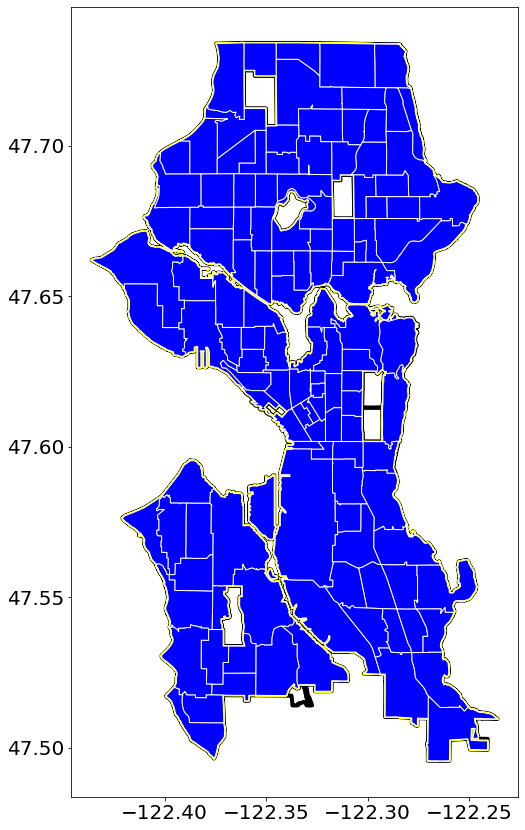

In [39]:
fig, ax = plt.subplots(figsize = (8, 16))

census_bounds.plot(ax=ax, facecolor='none', edgecolor='k', lw=4)
pop_tracts_2.plot(ax=ax, facecolor='green', edgecolor='yellow', lw=2)
pop_tracts_3.plot(ax=ax, facecolor='blue', edgecolor='white')